In [1]:
import erlab.plotting.erplot as eplt
import matplotlib.pyplot as plt

In [2]:
import xarray
# Before starting, we set some options for xarray.

# - The first option, ``display_expand_data=False``, will collapse the data by
#   default in the `repr` of DataArrays and Datasets.

# - The second option, ``keep_attrs=True``, ensures that the attributes of the data
#   are kept when performing operations such as sum and mean. Since parameters for
#   momentum conversion such as angle offsets and inner potential are stored as
#   attributes, this is important.
%config InlineBackend.figure_formats = ["svg", "pdf"]
plt.rcParams["figure.dpi"] = 96


_ = xarray.set_options(display_expand_data=False, keep_attrs=True)

Let's generate some example data, this time in angle coordinates.

In [3]:
from erlab.io.exampledata import generate_data_angles

dat = generate_data_angles(assign_attributes=True, seed=1).T
dat

<xarray.DataArray (eV: 500, beta: 60, alpha: 500)>
2.358 3.405 2.24 1.645 0.6441 ... 0.0004334 8.253e-07 6.374e-09 6.121e-12
Coordinates:
  * alpha    (alpha) float64 -15.0 -14.94 -14.88 -14.82 ... 14.88 14.94 15.0
  * beta     (beta) float64 -15.0 -14.49 -13.98 -13.47 ... 13.98 14.49 15.0
  * eV       (eV) float64 -0.45 -0.4489 -0.4477 -0.4466 ... 0.1177 0.1189 0.12
    xi       float64 0.0
    delta    float64 0.0
    hv       float64 50.0
Attributes:
    configuration:        1
    temp_sample:          20.0
    sample_workfunction:  4.5

Let us define a 2D cut from the map data we just generated.

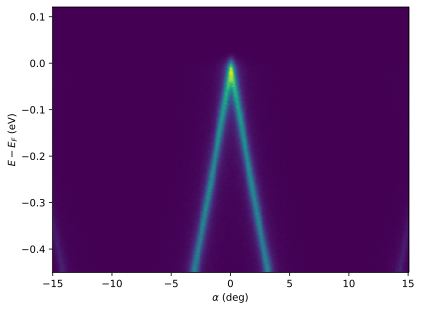

In [4]:
cut = dat.sel(beta=10.0, method="nearest")
eplt.plot_array(cut)

In [5]:
dat_kconv = dat.kspace.convert()
dat_kconv

Estimating bounds and resolution
Calculating destination coordinates
Converting ('eV', 'alpha', 'beta')  ->  ('eV', 'kx', 'ky')
Interpolated in 1.110 s


<xarray.DataArray (eV: 500, kx: 310, ky: 310)>
nan nan nan nan nan nan nan nan nan ... 0.01834 0.02405 nan nan nan nan nan nan
Coordinates:
    xi       float64 0.0
    delta    float64 0.0
    hv       float64 50.0
  * eV       (eV) float64 -0.45 -0.4489 -0.4477 -0.4466 ... 0.1177 0.1189 0.12
  * kx       (kx) float64 -0.8956 -0.8898 -0.884 -0.8782 ... 0.884 0.8898 0.8956
  * ky       (ky) float64 -0.8956 -0.8898 -0.884 -0.8782 ... 0.884 0.8898 0.8956
Attributes:
    configuration:        1
    temp_sample:          20.0
    sample_workfunction:  4.5
    delta_offset:         0.0
    xi_offset:            0.0
    beta_offset:          0.0

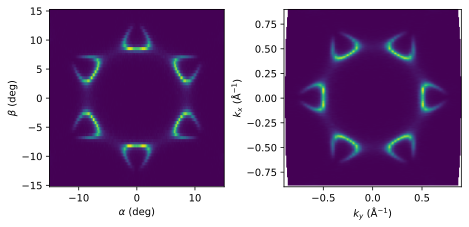

In [6]:
fig, axs = plt.subplots(1, 2, layout="compressed")
eplt.plot_array(dat.sel(eV=-0.3, method="nearest"), ax=axs[0], aspect="equal")
eplt.plot_array(dat_kconv.sel(eV=-0.3, method="nearest"), ax=axs[1], aspect="equal")

In [7]:
dat.kspace.offsets

delta,0.0
xi,0.0
beta,0.0


Since we haven't set any offsets, they are all zero. We will set the azimuthal angle to 60 degrees and the polar offset to 30 degrees and see what happens.

In [8]:
dat.kspace.offsets.update(delta=60.0, beta=30.0)

delta,60.0
xi,0.0
beta,30.0


In [9]:
dat_kconv = dat.kspace.convert()
dat_kconv

Estimating bounds and resolution
Calculating destination coordinates
Converting ('eV', 'alpha', 'beta')  ->  ('eV', 'kx', 'ky')
Interpolated in 0.494 s


<xarray.DataArray (eV: 500, kx: 380, ky: 398)>
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates:
    xi       float64 0.0
    delta    float64 0.0
    hv       float64 50.0
  * eV       (eV) float64 -0.45 -0.4489 -0.4477 -0.4466 ... 0.1177 0.1189 0.12
  * kx       (kx) float64 -2.495 -2.489 -2.483 ... -0.3111 -0.3053 -0.2995
  * ky       (ky) float64 -0.3431 -0.3373 -0.3315 -0.3257 ... 1.946 1.952 1.957
Attributes:
    configuration:        1
    temp_sample:          20.0
    sample_workfunction:  4.5
    delta_offset:         60.0
    xi_offset:            0.0
    beta_offset:          30.0

Plotting the converted data again, we can see the effect of angle offsets on the conversion.

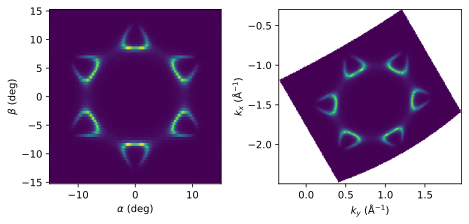

In [10]:
fig, axs = plt.subplots(1, 2, layout="compressed")
eplt.plot_array(dat.sel(eV=-0.3, method="nearest"), ax=axs[0], aspect="equal")
eplt.plot_array(dat_kconv.sel(eV=-0.3, method="nearest"), ax=axs[1], aspect="equal")